In [5]:
#This notebook contains the 3D test 4 of from the VP method paper using MHDFlows
# 4. Magnetohydrodynamic Taylor–Couette flow
using MHDFlows
using PyPlot
using HDF5,FFTW,FourierFlows
using LinearAlgebra: mul!, ldiv!

using Statistics
using PyCall,LazCh5
glob = pyimport("glob2")

PyObject <module 'glob2' from '/usr/local/lib/python3.6/dist-packages/glob2/__init__.py'>

In [8]:
device!(0)
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [17]:
function ChoFroceScheme2!(N_, sol, t, clock, vars, params, grid)
  str = string
  T   = eltype(vars.nonlinh1)
  f_ih = zeros(T,size(vars.nonlinh1));

  Φ1T,Φ2T,AT = vars.Φ1,vars.Φ2,vars.A;
  fox,foy,foz = params.fo[1,:],params.fo[2,:],params.fo[3,:];
  s1,s2 = params.s1,params.s2;  
  dt  = clock.dt;  
  Random_iterator!(Φ1T,Φ2T,AT);  
  v = -0;
  Offset = div(size(vars.ux)[1],2);  
  # Added for Large Scale Forcing
  k_conponment = length(Φ1T);

    
  #Create A,Φ2 to CPU if GPU is enable
  A  = Array{T}(AT);  
  Φ1 = Array{T}(Φ1T); 
  Φ2 = Array{T}(Φ2T);
  m,l = Array{T}(grid.m[:]),Array{T}(grid.l[:]);
  for (u_ind,i) ∈ zip([params.ux_ind,params.uy_ind,params.uz_ind],[1,2,3])
      @. f_ih*=0;  
      for k_i = 1:k_conponment
        k_fx = fox[k_i]+1;
        k_fy = findall(l.==foy[k_i])[1];
        k_fz = findall(m.==foz[k_i])[1];
        kf2 = k_fx^2+k_fy^2+k_fz^2; 
        f_ih[k_fx,k_fy,k_fz]  = A[1]*exp(v*kf2*dt)*exp(im/2*(Φ1[k_i]+Φ2[k_i]))*
                    (s1[i,k_i]*cos((Φ2[k_i]-Φ1[k_i])/2)+s2[i,k_i]*sin((Φ2[k_i]-Φ1[k_i])/2));
      end
      @. vars.nonlinh1*=0;
      copyto!(vars.nonlinh1, f_ih);   
      ldiv!(vars.nonlin1, grid.rfftplan, deepcopy(vars.nonlinh1));
      @. vars.nonlin1 = (1-params.χ)*vars.nonlin1;
      mul!(vars.nonlinh1, grid.rfftplan, vars.nonlin1) 

      N_[:,:,:,u_ind] .+= vars.nonlinh1;
  end
end
function Random_iterator!(Φ1,Φ2,A)
    #random generator ∈ [-1,1]
    rand1CPU(n::Int;T=Float32) = 2.0 .*(rand(T,n).-0.5);
    rand1CUDA(n::Int;T=Float32) = 2.0 .*(CUDA.rand(T,n).-0.5);
    
    rand1 = Φ1 isa CuArray ? rand1CUDA : rand1CPU;
    T = eltype(Φ2)
    k_conponment = length(Φ1);
    Φ_changefraction   = convert(T,0.02);
    A_changefraction   = convert(T,0.01);

    # For each time step, slowly changing the amplitude or phase by 1 or 2%
    Φ1 .= Φ1.*( 1 .+ 2*π .*rand1(k_conponment;T=T).*Φ_changefraction);
    Φ2 .= Φ2.*( 1 .+ 2*π .*rand1(k_conponment;T=T).*Φ_changefraction);
    #just 1 conponment for now
    A .= A.*(1.0 .+ rand1(1;T=T)*A_changefraction);
end    

function DivVCorrection(prob)
#= 
   Possion Solver for periodic boundary condition
   As in VP method, ∇ ⋅ B = 0 doesn't hold, B_{t+1} = ∇×Ψ + ∇Φ -> ∇ ⋅ B = ∇² Φ
   We need to find Φ and remove it using a Poission Solver 
   Here we are using the Fourier Method to find the Φ
   In Real Space,  
   ∇² Φ = ∇ ⋅ B   
   In k-Space,  
   ∑ᵢ -(kᵢ)² Φₖ = i∑ᵢ kᵢ(Bₖ)ᵢ
   Φ = F{ i∑ᵢ kᵢ (Bₖ)ᵢ / ∑ᵢ (k²)ᵢ}
=#  

  vars = prob.vars;
  grid = prob.grid;
  params = prob.params;
    #find Φₖ
    kᵢ,kⱼ,kₖ = grid.kr,grid.l,grid.m;
    k⁻² = grid.invKrsq;
    @. vars.nonlin1  *= 0;
    @. vars.nonlinh1 *= 0;       
    ∑ᵢkᵢUᵢh_k² = vars.nonlinh1;
    ∑ᵢkᵢUᵢ_k²  = vars.nonlin1;
    uxh = prob.sol[:, :, :, params.ux_ind];
    uyh = prob.sol[:, :, :, params.uy_ind];
    uzh = prob.sol[:, :, :, params.uz_ind];
    ∑ᵢkᵢUᵢh_k² = @. -im*(kᵢ*uxh + kⱼ*uyh + kₖ*uzh);
    ∑ᵢkᵢUᵢh_k² = @. ∑ᵢkᵢUᵢh_k²*k⁻²;  # Φₖ
    
    # B  = B* - ∇Φ = Bᵢ - kᵢΦₖ  
    uxh  .-= kᵢ.*∑ᵢkᵢUᵢh_k²;
    uyh  .-= kⱼ.*∑ᵢkᵢUᵢh_k²;
    uzh  .-= kₖ.*∑ᵢkᵢUᵢh_k²;
    
    #Update to Real Space vars
    ldiv!(vars.ux, grid.rfftplan, deepcopy(uxh));# deepcopy() since inverse real-fft destroys its input
    ldiv!(vars.uy, grid.rfftplan, deepcopy(uyh));# deepcopy() since inverse real-fft destroys its input
    ldiv!(vars.uz, grid.rfftplan, deepcopy(uzh));# deepcopy() since inverse real-fft destroys its input
end

DivVCorrection (generic function with 1 method)

In [18]:
function integration_with_save_VP(prob,file_path_and_name;dump_dt=1,loop_number=100,deg=[],file_number=1,A0 = Float32(5e6))
    t_next = prob.clock.t + dump_dt;
    KE_,ME_ = ProbDiagnostic(prob);
    if prob.clock.t == 0
        savefile(prob,0;file_path_and_name=file_path_and_name)
    end
    for i = 1:loop_number
        stepforward!(prob,deg,1);
        DivBCorrection(prob);
        DivVCorrection(prob);
        MHDupdatevars!(prob);

        t = prob.clock.t;
        
        if t>= t_next
           prob.vars.A .= A0;
           KE_,ME_ = ProbDiagnostic(prob);
           isnan(KE_) ? error("detected NaN! Quite the simulation right now.") : nothing;
           savefile(prob,file_number;file_path_and_name=file_path_and_name)
           t_next += dump_dt;
           file_number +=1;
            
        end
        
    end
end


function savefile(prob,file_number;file_path_and_name="/mnt/c/data/VP_test/Spectral_Test")
    space_0 = ""
    for i = 1:4-length(string(file_number));space_0*="0";end
    fw = h5open(file_path_and_name*"_t_"*space_0*string(file_number)*".h5","w")
    write(fw, "i_velocity",  Array(prob.vars.ux));
    write(fw, "j_velocity",  Array(prob.vars.uy));
    write(fw, "k_velocity",  Array(prob.vars.uz));
    write(fw, "i_mag_field", Array(prob.vars.bx));
    write(fw, "j_mag_field", Array(prob.vars.by));
    write(fw, "k_mag_field", Array(prob.vars.bz));
    write(fw, "time", prob.clock.t);
    close(fw) 
end

function ProbDiagnostic(prob)
    dV = (2π/prob.grid.nl)^3;
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    KE =  string(round(sum(vx.^2+vy.^2 + vz.^2)*dV,sigdigits=2));
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    ME =  string(round(sum(bx.^2+by.^2 + bz.^2)*dV,sigdigits=2));
    tt =  string(round(prob.clock.t,sigdigits=2));
    for i = 1:8-length(string(tt));tt= " "*tt;end
    for i = 1:8-length(string(ME));ME= " "*ME;end
    for i = 1:8-length(string(KE));KE= " "*KE;end
    println("t = $tt, KE = $KE, ME= $ME")
    return parse(Float32,KE),parse(Float32,ME)
end

ProbDiagnostic (generic function with 1 method)

In [19]:
function Taylor_Couette_Cylindrical_Mask_Function(grid;R₂=0.82π,R₁=0.32π)
    nx,ny,nz = grid.nx,grid.ny,grid.nz;
    x,y,z = grid.x,grid.y,grid.z;
    S = BitArray(undef, nx,ny,nz);
    
    for k ∈ 1:nz, j ∈ 1:ny,i ∈ 1:nx
        xᵢ,yᵢ,zᵢ = x[i],y[j],z[k];
        Rᵢ       = √(xᵢ^2+yᵢ^2);
        # S = 0 if inside fluid domain while S = 1 in the solid domain 
        S[i,j,k] = (R₂ >= Rᵢ >= R₁) ?  0 : 1; 
    end    
    #S[:,:,1] .=1;
    #S[:,:,end] .=1;
    S
end

function Taylor_Couette_Cylindrical_Mask_Function(grid;R₂=0.82π,R₁=0.32π)
    nx,ny,nz = grid.nx,grid.ny,grid.nz;
    x,y,z = grid.x,grid.y,grid.z;
    S = BitArray(undef, nx,ny,nz);
    
    for k ∈ 1:nz, j ∈ 1:ny,i ∈ 1:nx
        xᵢ,yᵢ,zᵢ = x[i],y[j],z[k];
        Rᵢ       = √(xᵢ^2+yᵢ^2);
        # S = 0 if inside fluid domain while S = 1 in the solid domain 
        S[i,j,k] = (R₂ >= Rᵢ >= R₁) ?  0 : 1; 
    end    
    #S[:,:,1] .=1;
    #S[:,:,end] .=1;
    S
end


function NoBoundary(grid;R₂=0.82π,R₁=0.32π)
    nx,ny,nz = grid.nx,grid.ny,grid.nz;
    x,y,z = grid.x,grid.y,grid.z;
    S = BitArray(undef, nx,ny,nz);
    S.=0;
    #S[:,:,1] .=1;
    #S[:,:,end] .=1;
    S
end

NoBoundary (generic function with 1 method)

In [20]:
function ProblemGeneratorTC3D!(prob;L0=2π,T=Float32)

  # Output Setting  
  x = Array(prob.grid.x);
  y = Array(prob.grid.y);
  z = Array(prob.grid.z);
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
  ux,uy,uz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);
  bx,by,bz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);
  U₀x,U₀y,U₀z = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);  
  V₀ = 1;
  r₀ = 0.32π;
  χ  = BitArray(Array(prob.params.χ));
  # Setup: Uθ = 1 if r ∈ 0.32π
  # Uθ =  r(dθ/dt) ê_θ
  # ̂e_θ  = - sinθ ̂i + cosθ ̂j; 
  for k ∈ 1:nz,j ∈ 1:ny,i ∈ 1:nx
    r = sqrt(x[i]^2+y[j]^2);
    θ = atan(y[j],x[i]) ;
    θ = isnan(θ) ? π/2 : θ
    sinθ = sin(θ);
    cosθ = cos(θ);
    #sinθ =  θ < 0 ? sin(-θ) : sin(θ)
    #uz[i,j,k] =  ifelse(χ[i,j,k], 0,(rand(Float32,1)[1]-0.5)*1e-5);
    #bz[i,j,k] =  B0;
    if r<=0.92π    
        ux[i,j,k] =  -r*sinθ;
        uy[i,j,k] =   r*cosθ;
        U₀x[i,j,k] = -r*sinθ;
        U₀y[i,j,k] =  r*cosθ;  
    end        
  end
  #v_θ = v/r 
  bx = @. √(1e-3)*ux;
  by = @. √(1e-3)*uy;
  bz = @. √(1e-3)*uz;       
  #V-field Wall setting    
  copyto!(prob.params.U₀x, deepcopy(U₀x));
  copyto!(prob.params.U₀y, deepcopy(U₀y)); 
  copyto!(prob.params.U₀z, deepcopy(U₀z));  
  #B-field Wall setting
  copyto!(prob.params.B₀x, deepcopy(bx));    
  copyto!(prob.params.B₀y, deepcopy(by));    
  copyto!(prob.params.B₀z, deepcopy(bz));    
    
    
  copyto!(prob.vars.ux, deepcopy(ux));
  copyto!(prob.vars.uy, deepcopy(uy));
  copyto!(prob.vars.uz, deepcopy(uz));
  copyto!(prob.vars.bx, deepcopy(bx));
  copyto!(prob.vars.by, deepcopy(by));
  copyto!(prob.vars.bz, deepcopy(bz));

  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(bxh, prob.grid.rfftplan, prob.vars.bx);
  mul!(byh, prob.grid.rfftplan, prob.vars.by);
  mul!(bzh, prob.grid.rfftplan, prob.vars.bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
  prob.sol[:, :, :, prob.params.bx_ind] .= bxh;
  prob.sol[:, :, :, prob.params.by_ind] .= byh;
  prob.sol[:, :, :, prob.params.bz_ind] .= bzh;
      
  return uz
end
function getUθ(ux,uy;L=2π)
  # Uθ =  r(dθ/dt) ê_θ
  # ̂e_θ  = - sinθ ̂i + cosθ ̂j;  
  nx,ny = size(ux);  
  dev  = CPU();
  Lx = Ly = L;
  T  = Float32;
  grid = TwoDGrid(dev, nx, Lx, ny, Ly; T=T)
  Uθ = zeros(nx,ny)
  for j ∈ 1:ny, i ∈ 1:nx
      r = sqrt(grid.x[i]^2+grid.y[j]^2);
      θ = atan(grid.y[j],grid.x[i]) ;
      θ = isnan(θ) ? π/2 : θ
      sinθ = sin(θ);
      cosθ = cos(θ);
      Uθ[i,j] = -sinθ*ux[i,j] + cosθ*uy[i,j]
  end
  return Uθ    
end

getUθ (generic function with 1 method)

In [15]:
#parameters
N =  170;
Nz=  170;#div(N,32);
Lx = 2π;
Lz = 2π;

Re = 10000;
Rₑ,Rᵢ = 0.82*pi,0.32*pi
L  = Rₑ - Rᵢ;
U  = 1;
ν  = U*L/Re
η = ν; # Pr = 1;
#Ha = 7
#B0 = √(η*ν)/L*Ha
#dt = 2.5e-3;
#dt = 2.35e-3;
dt = 2.5e-3;
A0 = Float32(5e5);
#A0 = Float32(2e5); #onlu increase from 0.69 -> 1.1 between 0 to 15
#A0 = Float32(1e6); # nan at t= 24/Re = 15k
#A0 = Float32(5e5); # dt change to 2.5e-3, Re  = 155k
# Testing the problem 
nothingfunction(args...) = nothing;
CPUprob = VP_Problem(GPU();
        # Numerical parameters
                      nx = N,
                      Lx = Lx,
                      ny = N,
                      Ly = Lx,
                      nz = Nz,
                      Lz = Lz,
         # Drag and/or hyper-viscosity for velocity/B-field
                       ν = ν,
                      nν = 1,
                       η = η,
        # Timestepper and equation options
                      dt = dt,
                 stepper = "RK4",
        # Force Driving par?ameters       
                   calcF = ChoFroceScheme2!,
                      A0 = A0,
                      kf = 25.0,
        # Maskfunction 
             Maskfuncion = Taylor_Couette_Cylindrical_Mask_Function,
        # Float type and dealiasing
                       T = Float32)

Problem
  ├─────────── grid: grid (on GPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

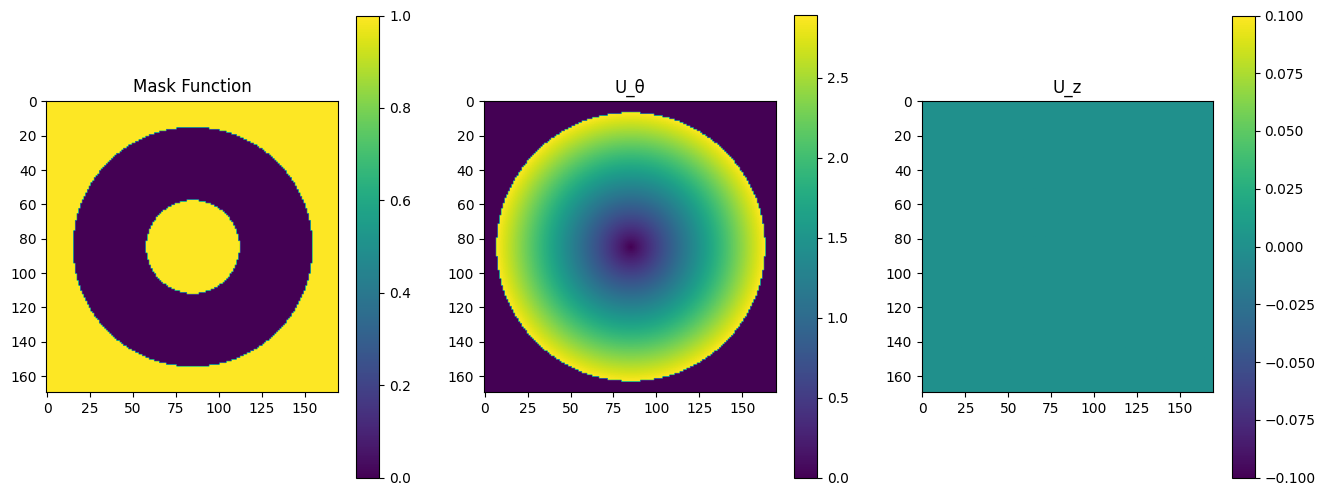

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6328370e48>

In [21]:
uz = ProblemGeneratorTC3D!(CPUprob);
Uθ = getUθ(Array(CPUprob.vars.ux[:,:,1]),Array(CPUprob.vars.uy[:,:,1]);L=2π)
Sx,Sy = copy(CPUprob.vars.ux),copy(CPUprob.vars.uy);
figure(figsize=(16,6))
subplot(131)
imshow(Array(CPUprob.params.χ)[:,:,2])
title("Mask Function");
colorbar()
subplot(132)
imshow(Uθ)  
title("U_θ");
colorbar()

subplot(133)
imshow(Array(CPUprob.vars.uz)[:,:,2]')
title("U_z")
colorbar()

In [22]:
#loopprob(CPUprob,1000)
# 1 loop = 1.5s  
dump_dt = 1.0
loop_number = 200/CPUprob.clock.dt + 1
file_number = round(Int,CPUprob.clock.t/dump_dt+1)
file_path_and_name = "/mnt/c/data/MHD_Cylinder/P5DA_"
integration_with_save_VP(CPUprob,file_path_and_name;dump_dt=dump_dt,loop_number=loop_number,file_number=file_number,A0 = A0)

t =      0.0, KE =    690.0, ME=     0.69
t =      1.0, KE =    700.0, ME=     0.76
t =      2.0, KE =    700.0, ME=      1.1
t =      3.0, KE =    690.0, ME=      2.6
t =      4.0, KE =    680.0, ME=      4.0
t =      5.0, KE =    670.0, ME=      5.3
t =      6.0, KE =    660.0, ME=      7.7
t =      7.0, KE =    650.0, ME=     11.0
t =      8.0, KE =    630.0, ME=     15.0
t =      9.0, KE =    620.0, ME=     19.0
t =     10.0, KE =    610.0, ME=     25.0
t =     11.0, KE =    610.0, ME=     34.0
t =     12.0, KE =    590.0, ME=     41.0
t =     13.0, KE =    590.0, ME=     47.0
t =     14.0, KE =    580.0, ME=     54.0
t =     15.0, KE =    570.0, ME=     58.0
t =     16.0, KE =    570.0, ME=     65.0
t =     17.0, KE =    560.0, ME=     72.0
t =     18.0, KE =    560.0, ME=     79.0
t =     19.0, KE =    560.0, ME=     83.0
t =     20.0, KE =    550.0, ME=     86.0
t =     21.0, KE =    550.0, ME=     90.0
t =     22.0, KE =    550.0, ME=     95.0
t =     23.0, KE =    540.0, ME=  

In [ ]:
#Note 1.
# Incrase the energy 
# Reduce the Re further

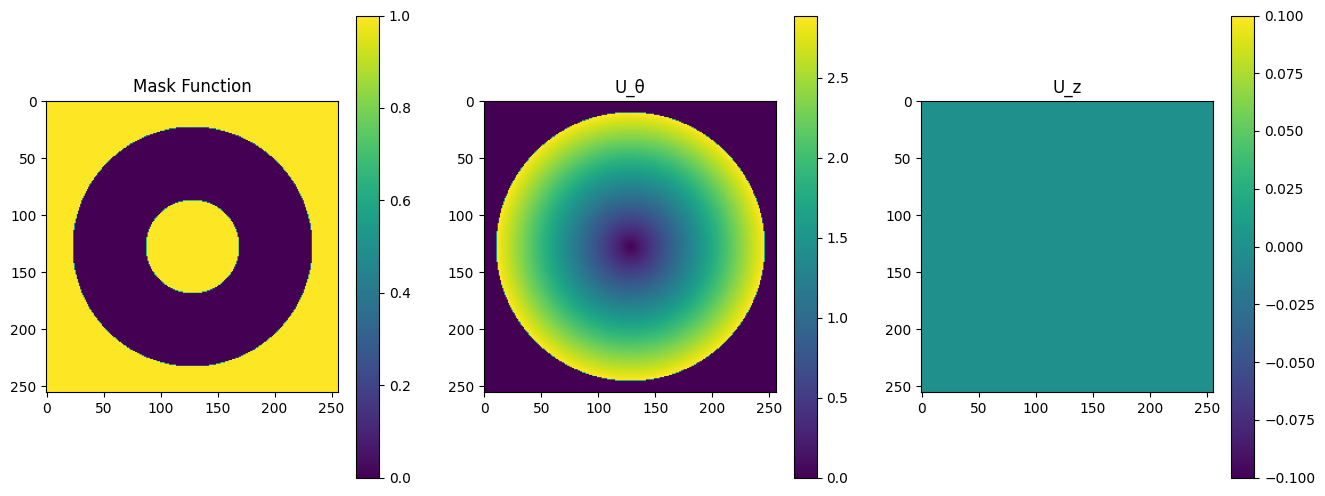

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6e9042fac8>

In [11]:
Uθ = getUθ(Array(CPUprob.vars.ux[:,:,30]),Array(CPUprob.vars.uy[:,:,30]);L=2π)
Sx,Sy = copy(CPUprob.vars.ux),copy(CPUprob.vars.uy);
figure(figsize=(16,6))
subplot(131)
imshow(Array(CPUprob.params.χ)[:,:,2])
title("Mask Function");
colorbar()

subplot(132)
imshow(Uθ)  
title("U_θ");
colorbar()

subplot(133)
imshow(Array(CPUprob.vars.uz)[64,:,:]')
title("U_z")
colorbar()

# Restart section

In [12]:
function Problemrestart!(prob,file_loc;T=Float32)
  f = h5open(file_loc,"r")
  ux = read( f , "i_velocity",  ) ;
  uy = read( f , "j_velocity",  ) ;
  uz = read( f , "k_velocity",  ) ;
  bx = read( f , "i_mag_field", ) ;
  by = read( f , "j_mag_field", ) ;
  bz = read( f , "k_mag_field", ) ;
  close(f)

  copyto!(prob.vars.ux, deepcopy(ux));
  copyto!(prob.vars.uy, deepcopy(uy));
  copyto!(prob.vars.uz, deepcopy(uz));
  copyto!(prob.vars.bx, deepcopy(bx));
  copyto!(prob.vars.by, deepcopy(by));
  copyto!(prob.vars.bz, deepcopy(bz));

  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(bxh, prob.grid.rfftplan, prob.vars.bx);
  mul!(byh, prob.grid.rfftplan, prob.vars.by);
  mul!(bzh, prob.grid.rfftplan, prob.vars.bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
  prob.sol[:, :, :, prob.params.bx_ind] .= bxh;
  prob.sol[:, :, :, prob.params.by_ind] .= byh;
  prob.sol[:, :, :, prob.params.bz_ind] .= bzh;
      
  return uz
end

Problemrestart! (generic function with 1 method)

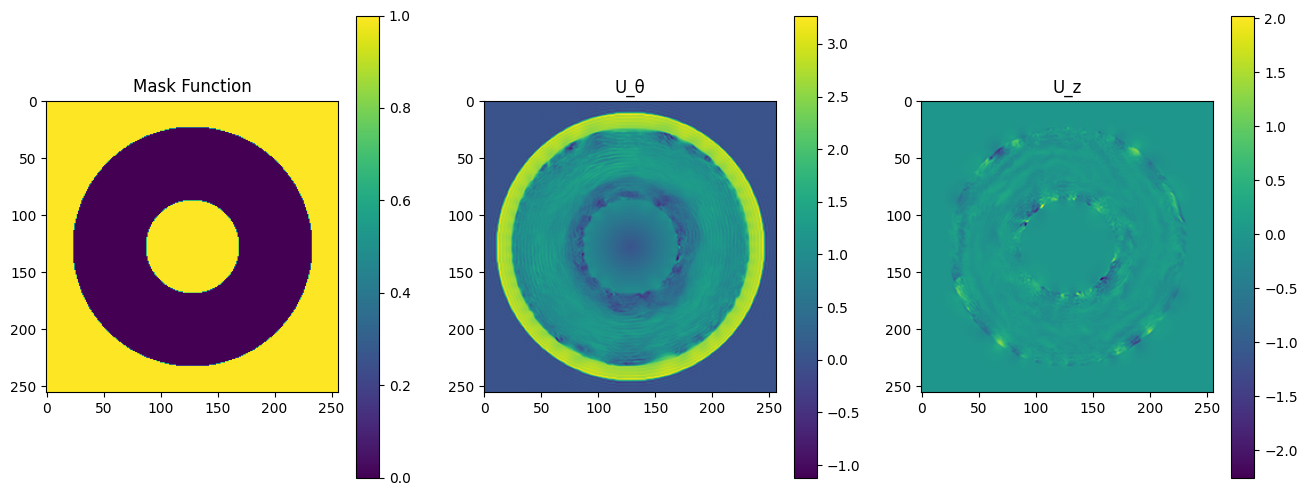

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4c908f2898>

In [13]:
ff = glob.glob("/mnt/c/data/MHD_Cylinder/P4D__t_0050.h5");
CPUprob.clock.dt = 2.5e-3
CPUprob.clock.t  = 50

Problemrestart!(CPUprob,ff[1];T=Float32);
Uθ = getUθ(Array(CPUprob.vars.ux[:,:,1]),Array(CPUprob.vars.uy[:,:,1]);L=2π)
Sx,Sy = copy(CPUprob.vars.ux),copy(CPUprob.vars.uy);
figure(figsize=(16,6))
subplot(131)
imshow(Array(CPUprob.params.χ)[:,:,2])
title("Mask Function");
colorbar()

subplot(132)
imshow(Uθ)  
title("U_θ");
colorbar()

subplot(133)
imshow(Array(CPUprob.vars.uz)[:,:,12]')
title("U_z")
colorbar()

In [ ]:
for i = 1:150
    stepforward!(CPUprob,1);
    DivBCorrection(CPUprob);
    MHDupdatevars!(CPUprob);
end
Uθ = getUθ(Array(CPUprob.vars.ux[:,:,30]),Array(CPUprob.vars.uy[:,:,30]);L=2π)
Sx,Sy = copy(CPUprob.vars.ux),copy(CPUprob.vars.uy);
figure(figsize=(16,6))
subplot(131)
imshow(Array(CPUprob.params.χ)[:,:,2])
title("Mask Function");
colorbar()

subplot(132)
imshow(Uθ)  
title("U_θ");
colorbar()

subplot(133)
imshow(Array(CPUprob.vars.uz)[64,:,:]')
title("U_z")
colorbar()